In [40]:
# import python scripts
from utils.functions_misc import *
from utils.structural import * 
from utils.functional import * 
from utils.distance import * 

In [41]:
# importing data
main_dir = "/Users/gabrielhaw/Connectome/"
# COBRE data
subject_dir = main_dir + "temp/"
participant_data = main_dir + "misc/participants_CONNECT_matched_07052025.csv"
# distance matrices
left_path = main_dir + "geodesic_distances/Left_hemisphere"
right_path = main_dir + "geodesic_distances/Right_hemisphere"

# processing distance matrices
left_dist, right_dist = average_distances(left_path, right_path, participant_data)

# loading in all final processed subject matrices
fc_mat_dir = "/Users/gabrielhaw/Connectome/subject_func_connectivity/"
sc_mat_dir = "/Users/gabrielhaw/Connectome/subject_struct_connectivity/"
sc_path_dir = "/Users/gabrielhaw/Connectome/subject_distances/"

# structural, functional connectivity & distances for each hemisphere (r: right, l: left)
lmatsc, rmatsc = struct_connect(sc_mat_dir)
lmatfc, rmatfc = funct_connect(fc_mat_dir)
llength, rlength = struct_connect(sc_path_dir)

print("all matrices loaded correctly")

all matrices loaded correctly


In [10]:
# distance-dependent consensus matrices 
print("structural:")
_, _, structural_left, _ = process_hemisphere(lmatsc, left_dist, nbins=41)
_, _, structural_right, _ = process_hemisphere(rmatsc, right_dist, nbins=41)

print("functional:")
# functional connectivity matrics
functional_left, functional_right = fconstruct_consensus(lmatfc, sthresh=0), fconstruct_consensus(rmatfc, sthresh=0)
# final correlation matrices
corrl, corrr = impute(functional_left),  impute(functional_right)

structural:
Total edges in G: 4613.0
Total edges in Gc: 2306.0
Total edges in G: 4615.0
Total edges in Gc: 2307.0
functional:
Edges removed: 0/50625 (0.0%)
Edges removed: 0/49729 (0.0%)


In [11]:
# left hemisphere embedding, Brainspace
embedding_left = gradient_(corrl, sparsity=0.9, kernel=None, n_components = 3, approach="le", z_score=True, savedf=False)
# left hemisphere embedding, Brainspace
embedding_right = gradient_(corrr, sparsity=0.9, kernel=None, n_components = 3, approach="le", z_score=True, savedf=False)

/Users/gabrielhaw/ConnectomeCode/working/.venv/lib/python3.12/site-packages/brainspace/gradient/embedding.py:206: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')
/Users/gabrielhaw/ConnectomeCode/working/.venv/lib/python3.12/site-packages/brainspace/gradient/embedding.py:206: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


In [35]:
# global_variogram(left_dist, structural_left, sigma=0.1, n_bins=20, binmethod="uniform")
# global_variogram(right_dist, structural_right, sigma=0.1, n_bins=20, binmethod="uniform")
right = variogram(right_dist, structural_right, sigma=7, n_bins=20, binmethod="uniform", plot=False)
left = variogram(left_dist, structural_left, sigma=7, n_bins=20, binmethod="uniform", plot=False)


In [6]:
# map the principal gradient values to the left and right hemipsheres
right['PC1'] = right['regions'].map(embedding_right.set_index('regions')['PC1'])
left['PC1'] = left['regions'].map(embedding_left.set_index('regions')['PC1'])

# center the PC1 values, differentiate unimodal to transmodal 
left_center = left["PC1"].mean()
right_center = right["PC1"].mean()

# get the unimodal and transmodal regions
unimodal_right = right[right["PC1"] < right_center]
transmodal_right = right[right["PC1"] > right_center]

unimodal_left = left[left["PC1"] < left_center]
transmodal_left = left[left["PC1"] > left_center]

# print(f"right effective range: {unimodal_right["effective_range"].mean()-transmodal_right["effective_range"].mean()}")
# print(f"left effective range: {unimodal_left["effective_range"].mean()- transmodal_left["effective_range"].mean()}")
# print(f"right sill: {unimodal_right["sill"].mean()-transmodal_right["sill"].mean()}")
# print(f"left sill: {unimodal_left["sill"].mean()- transmodal_left["sill"].mean()}")

# perform t-test
def t_test(x, y):
    """function to perform t-test between unimodal and transmodal regions""" 
    t_stat, p_val = stats.ttest_ind(x, 
                                      y, equal_var=False)
    return t_stat, p_val

t_stat, p_val = t_test(unimodal_left["effective_range"], transmodal_left["effective_range"])
t_stat, p_val = t_test(unimodal_left["sill"], transmodal_left["sill"])


In [7]:
# find regions with high range and low sill
rank_regions_table(right, high_range=True, high_sill=False, top_n=10)

,regions,effective_range,sill,combined_rank
90,middletemporal_9,81.408573,0.079175,14.0
15,entorhinal_1,74.574430,0.069129,29.0
156,rostralanteriorcingulate_1,74.701294,0.081633,36.0
99,parahippocampal_3,72.202809,0.069046,41.0
81,medialorbitofrontal_5,74.374843,0.095680,48.0
221,temporalpole_1,72.895996,0.087784,49.0
34,inferiorparietal_7,78.770701,0.109102,50.0
98,parahippocampal_2,72.454652,0.095096,57.0
83,middletemporal_2,76.562050,0.111694,58.0
183,superiorfrontal_5,70.664775,0.075969,58.0


In [ ]:
## functions to determine an adequate sigma, taking the sigma which leads to a stable rmse and r2 estimates
# df_sigma_choice_right = evaluate_sigma(right_dist, Gwr, n_bins=20, binmethod="uniform")
# df_sigma_choice_left = evaluate_sigma(left_dist, Gwl, n_bins=20, binmethod="uniform")
# create two subplots
# fig, axs = plt.subplots(2, 2, figsize=(12, 8))
# # right hemisphere
# sigma_(df_sigma_choice_right, n=1.2, axes=axs[0])
# # left hemisphere
# sigma_(df_sigma_choice_left, n=1.2, axes=axs[1])
# plt.tight_layout()
# plt.show()

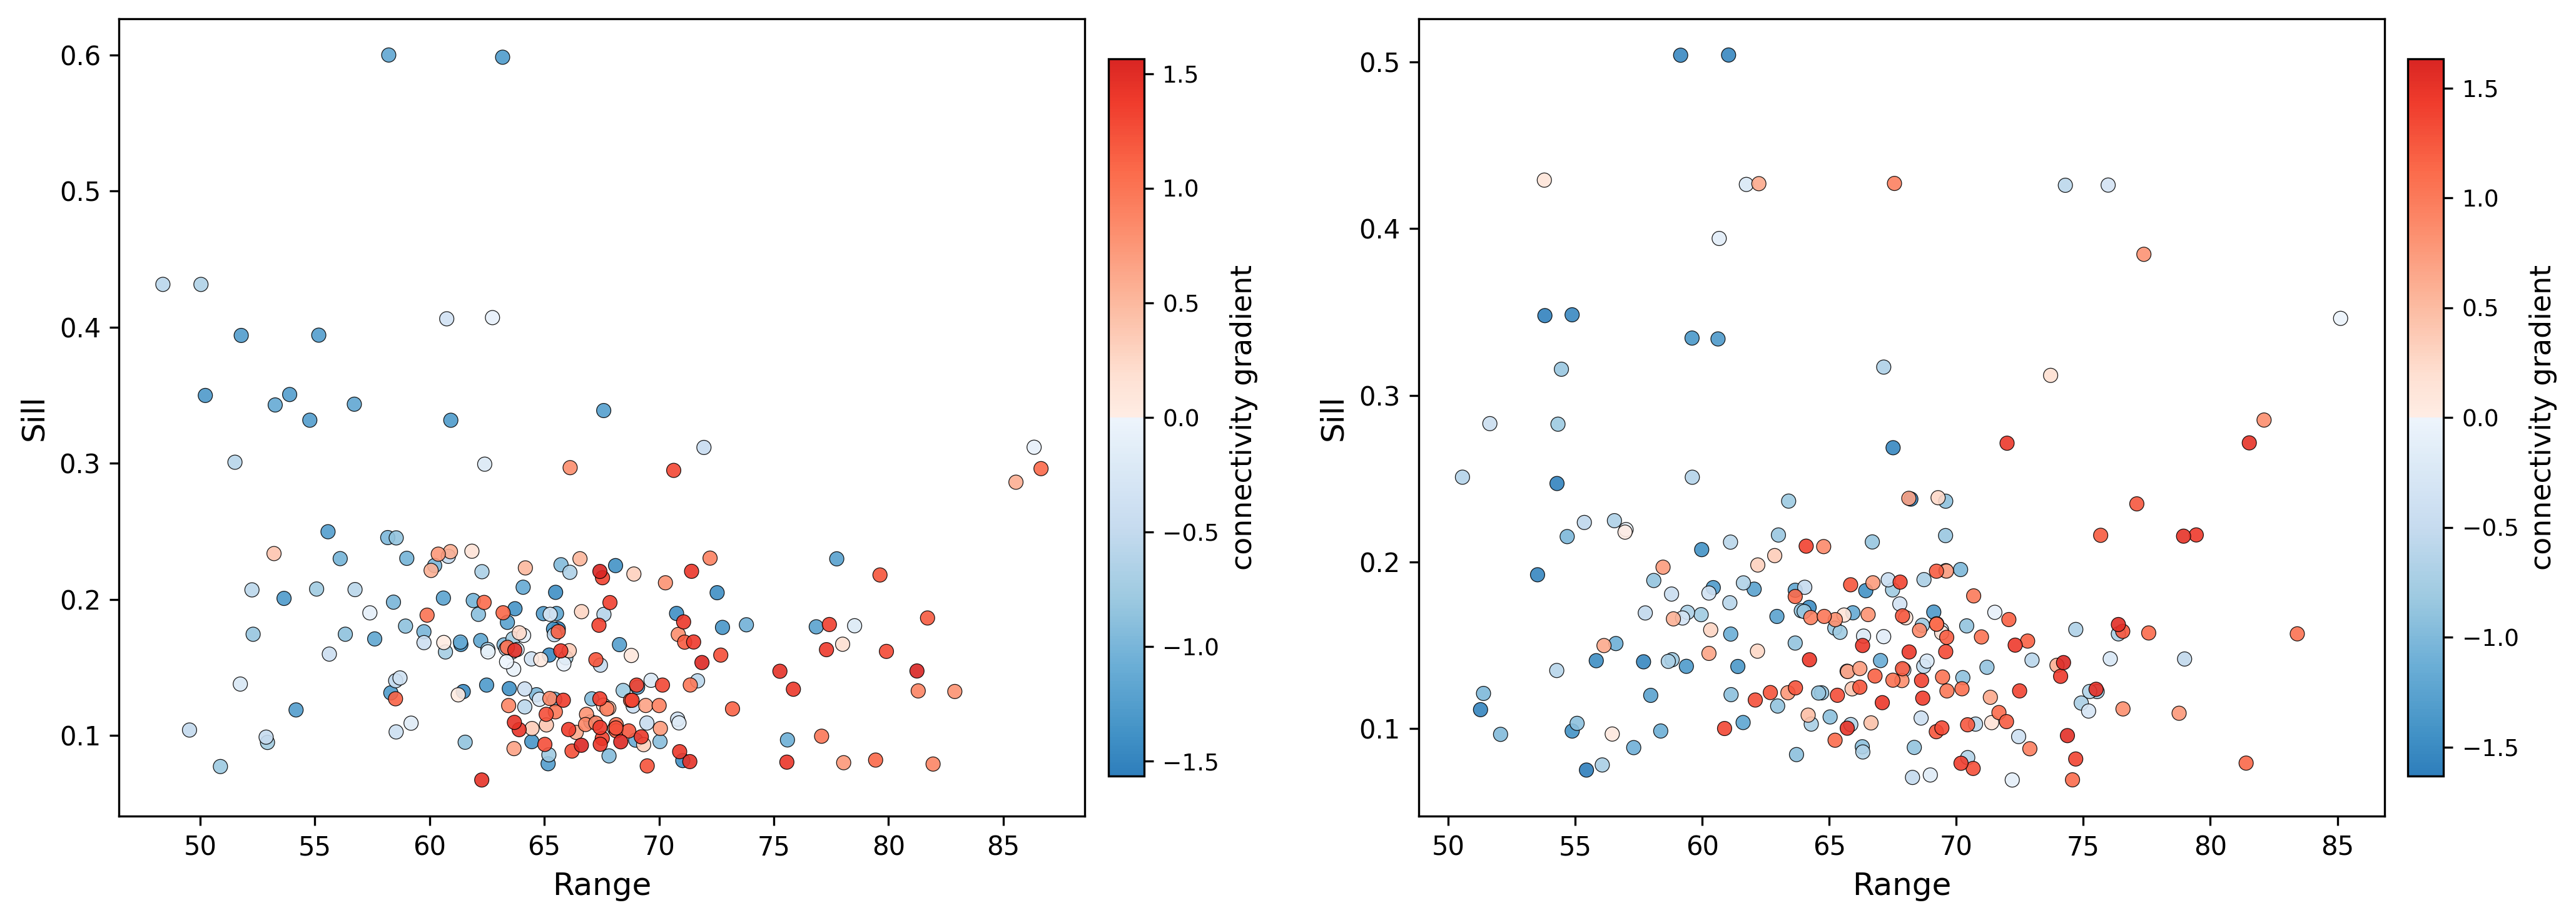

/Users/gabrielhaw/ConnectomeCode/working/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (448). n_quantiles is set to n_samples.
  warnings.warn(


In [8]:
# to generate scatterplot
fig, axes = rs_panel_plot(left, embedding_left, right, embedding_right)

# normalise features across both hemispheres, for cross hemisphere comparison
combined = pd.concat([left, right])
scaler = QuantileTransformer()
scaler.fit(combined[['effective_range', 'sill']])

# preprocess and plot
gradient_left = preprocess_data(left, embedding_left, scaler)
gradient_right = preprocess_data(right, embedding_right, scaler)

# dendogram analysis
dendrogram(gradient_left, path=None, save=False, plot_show=False, savename="dendrogram_left.png")
dendrogram(gradient_right, path=None, save=False, plot_show=False, savename="dendrogram_right.png")

In [ ]:
# permutation testing using range and sill across hemispheres
df_perma = perma_helper(left, left_dist, right, right_dist, perms_n=100000)


Running permutation test: left, effective_range
Running permutation test: left, sill
Running permutation test: right, effective_range
Running permutation test: right, sill
  hemisphere          feature  observed_r     p_val
0       left  effective_range    0.410360  0.027940
1       left             sill   -0.341168  0.069609
2      right  effective_range    0.444224  0.017500
3      right             sill   -0.265657  0.070529


In [10]:
# permutation testing for gradient and range + sill across hemispheres
grad_left_perma = perma_gradient(embedding_left, left, n_perms=100000)
grad_left_perma = perma_gradient(embedding_right, right, n_perms=100000)

Sill vs Gradient: correlation = -0.09, p = 0.1905
Range vs Gradient: correlation = 0.26, p = 0.00014
Sill vs Gradient: correlation = -0.12, p = 0.0844
Range vs Gradient: correlation = 0.18, p = 0.00723


In [ ]:
# annotation file
annot_path = "/Users/gabrielhaw/Connectome/misc/annot_fs7/rh.lausanne500.annot"

# from nilearn get fsaverage
fsaverage = load_fsaverage('fsaverage')
fsaverage_sulc = load_fsaverage_data(mesh='fsaverage', data_type='sulcal')

surf_map = map_surf_values_from_annot(
    annot_path,
    region_values=right,
    label_col="regions",
    value_col="sill"
)

# center your data around the mean from the DataFrame
mean_range = left["sill"].mean()
surf_map_centered = surf_map - mean_range

# clip outliers to prevent skewing
clip_val = np.nanpercentile(np.abs(surf_map_centered), 95)
vmin = -clip_val
vmax = clip_val

# function to plot the cortical surface
plot_left_hemisphere_with_colorbar(
    surf_map=surf_map_centered,
    fsaverage=fsaverage,
    sulc_map=fsaverage_sulc,
    vmin=vmin,
    vmax=vmax,
    label='Effective range',
    output_file='left_hemisphere_plot_sill.png',
    hemi="left",
    dpi=600  # high-resolution
)

[get_dataset_dir] Dataset found in /Users/gabrielhaw/nilearn_data/fsaverage

[get_dataset_dir] Dataset found in /Users/gabrielhaw/nilearn_data/fsaverage

[get_dataset_dir] Dataset found in /Users/gabrielhaw/nilearn_data/fsaverage